In [1]:
from IPython.display import HTML

HTML('''<script>var show_code = true;function toggle(){if(show_code == true){$('div.input').hide();}else{ 
$('div.input').show();} show_code = !show_code;} $(document).ready(toggle)</script><h4 style="color:lightgray">
<i>Wes Cobb's 2017-07-10 Presentation for the Houston Data Visualization Meetup. Clicking <a 
href="javascript:toggle()">here</a> toggles code visibility</i>''')

In [2]:
import os
import re
import sys
import math
import json
import time
import copy
import nltk
import pickle
import pprint
import warnings
import matplotlib
import numpy as np
import pandas as pa
import networkx as nx
from nltk.corpus import words
from nltk.collocations import *
import matplotlib.pyplot as plt
from operator import itemgetter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

pa.set_option("precision",3)
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}



<img src="outputs/images/title.png"></img>


## Introduction

Natural Language Processing is a subject that focuses on analyzing the form, structure, sentiment, and semantic content of language.  _Historically_, and even most of the time today, this means analyzing linguistic data expressed as text. 

At least to start out with, this is very different than the types of data traditional data science uses -- organized lists and tables of numbers.  In a sense the challenge of Natural Language Processing is to devise means of efficiently convert text data into numbers that can be analyzed with more traditional tools.

I work for a large multinational corporation in the Houston area and (as you might expect) we have LOTS of data. That data is both structured data (stored in SQL databases) and unstructured data (in the form of images, blobs, pdf files, receipts, reports, briefings, etc).  We have on the order of 5 _million_ gigabytes of structured data and 100 million gigabytes of unstructured data.  Look at that ratio -- there is 20x more unstructured data than structured data!  The upshod of all of this is that if you're someone who works with data, sooner or later you're going to be spending at least some of your time doing natural language processing.  

This notebook is intended to provide a very basic introduction to some of the most common types of natural language processing that you'll see people using these days. No pretenses are being made here about rigor or completeness -- I am most definitely not a expert in this field, but I do have to work with from time to time and what I've tried to capture here is some techniques and tools that I actually find myself using for work.  Hopefully this will be useful to people in getting started with the subject. 

## 1 Preparing the document(s) to be worked with...

One of the first things that you run into with NLP is that you have to deal with lots of different types of document formats.  You usually don't have the luxury of starting with a nice clean text file -- it's almost always someones proprietary binary format.  To be realistic we'll look at a few different types of documents that I've downloaded from the internet in various formats.  Some are from Google's Project Gutenberg (https://www.gutenberg.org/) in the epub format.  I've also thrown in something in Adobe's PDF format and a book converted to Microsoft Word's "docx" format. 

### 1.1 Find the documents to be worked with...

First of all let's set up a directory structure to work with.  Take all of the input files and put them into the directory called "inputs".  A small number of reference images (things that we'll use for decorating word clouds) will go into the directory called "images" as will copies of the graphics that we produce.  As we're doing our processing we'll store <i>plain text</i> intermediate results in "toutputs" and <i>json format</i> intermediate results in "joutputs".

In [3]:
## put input files in this directory...
INPUT_FILES    = "inputs" # where we find data

## the apache's TIKA package for converting things into txt format...
TIKA_HOME      = "/opt/apache/tika"

## stanford's CoreNLP package for annotating/analyzing documents.
#CORENLP_HOME   = "/opt/CoreNLP/stanford-corenlp-full-2017-12-09" # version 3.6.0
#CORENLP_HOME   = "/opt/CoreNLP/stanford-corenlp-full-2016-10-31" # version 3.7.0
CORENLP_HOME   = "/opt/CoreNLP/stanford-corenlp-full-2017-06-09"  # version 3.8.0

## you can set these to point anywhere you like as long as you're consistent
IMAGE_FILES    = "outputs/images" # where we store images that we generate...
TXT_OUTPUTS    = "outputs/text"   # where we store the results of native-format to txt conversions
JSON_OUTPUTS   = "outputs/json"   # where we store annotations made on the converted txt files...
PICKLE_FILES   = "outputs/pickle" # where the python pickle archives are stored...

## as long as you are working with a modest number of documents at one time it's fine to display the
## images in-line in the notebook here.  if you have more than a few dozen documents though you may 
## run into problems -- with 100 documents for example Chrome, Firefox, Safari, and Internet Explorer
## all *crash* with out-of-memory errors (the browsers are only allowed to use so much memory and 
## then they quit) -- so if you have a LOT of documents set DISPLAY_IMAGES = False, and then just
## fetch the images out of the IMAGE_FILES directory after the notebook finishes processing them.
DISPLAY_IMAGES = True

## a handful of small utility functions for constructing filenames -- these functions
## don't do much, but they drastically improve the readability of the later code...
def image_file(filestem, prefix='', image_dir=IMAGE_FILES):
    if (prefix == ''):
        return ("%s/%s.png" % (image_dir, filestem))
    # otherwise add in the prefix...
    return ("%s/%s_%s.png" % (image_dir, prefix, filestem))

def text_file(filestem, text_dir=TXT_OUTPUTS, suffix=True):
    if (suffix == False):
        return ("%s/%s" % (text_dir, filestem))
    # otherwise add in the suffix
    return ("%s/%s.txt" % (text_dir, filestem))
    
def json_file(filestem, json_dir=JSON_OUTPUTS):
    return ("%s/%s.json" % (json_dir, filestem))

def pickle_file(filestem, pickle_dir=PICKLE_FILES):
    return ("%s/%s.pkl" % (pickle_dir, filestem))

            nlp_talk
                  \__________ inputs         (our input documents are going here)
                   \_________ outputs/images (bwoval.png, rgbcrown.png, title.png + images we generate)
                    \________ outputs/text   (intermediate '.txt' files generated from the input files)
                     \_______ outputs/json   (intermediate '.json' files generated from the input files)
                      \______ outputs/pickle (intermediate '.pkl' files containing calculation results)

The top level directory will contain this file that you're currently looking at as well as a data product ("docs.pkl") that will contain some useful working data about the documents.  To save time I've already gone and collected some files from the internet and put them into the "inputs" folder as you can see:

In [4]:
# get the list of files in the ./inputs directory and print it out...
if (os.path.exists(INPUT_FILES) == True):
    input_files = os.listdir(INPUT_FILES)
    if (len(input_files) == 0):
        print("\tDirectory \'%s\' contains no files!" % INPUT_FILES)
    else:
        print("\tDirectory \'%s\' contains %d file(s):" % (INPUT_FILES,len(input_files)))
        input_counter = 0
        for input_file in input_files:
            input_counter += 1
            print("\t[%d] \'%s\'" % (input_counter, input_file))

	Directory 'inputs' contains 4 file(s):
	[1] 'A Field Guide to Data Science.pdf'
	[2] 'Anthem.odt'
	[3] 'The Art of War.docx'
	[4] 'The Prince and the Pauper.epub'


The first thing that we'll need to do is convert the documents into a form that we can actually work with -- plain text.  To do this we'll use the Apache Tika conversion engine.

### 1.2 Convert the documents into plain text form...

Apache Tika (see https://tika.apache.org/) is Java-based package for batch-processing files from many formats (.docx, .pptx, .xls, .pdf, .odt, .mbox,.epub, and more) into chosen formats (.txt, .xml, and .json).  There are several ways that you can run it, but mostly people either access it directly through the python API (see: https://github.com/chrismattmann/tika-python.git) or they run it via the command line and batch process anything in some specified directory with the outputs being sent to somewhere else.  

We're going to use the latter approach here (that's why I set up the directory structure mentioned above) But we'll stay inside our Jupyter notebook and launch a python command line instance to do the work:

In [5]:
beg_t = time.time()
print("\tConverting documents...\n")
status = os.system("java -jar /opt/apache/tika/tika-app-1.14.jar -t -i ./%s -o ./%s/" % (INPUT_FILES, TXT_OUTPUTS))
if (status != 0):
    print("\tTika: conversion successful")

# get the list of files in the TXT_OUTPUT directory and print it out...
if (os.path.exists(TXT_OUTPUTS) == True):
    txt_outputs = os.listdir(TXT_OUTPUTS)
    if (len(txt_outputs) == 0):
        print("\tDirectory \'%s\' contains no files!" % TXT_OUTPUTS)
    else:
        print("\tDirectory \'%s\' contains %d file(s):" % (TXT_OUTPUTS, len(txt_outputs)))
        toutput_counter = 0
        for txt_output in txt_outputs:
            toutput_counter += 1
            print("\t[%d] \'%s\'" % (toutput_counter, txt_output))   
end_t = time.time()
print("\n\tDocument conversion required %.2fs" % (end_t - beg_t))

	Converting documents...

	Directory 'outputs/text' contains 4 file(s):
	[1] 'A Field Guide to Data Science.pdf.txt'
	[2] 'Anthem.odt.txt'
	[3] 'The Art of War.docx.txt'
	[4] 'The Prince and the Pauper.epub.txt'

	Document conversion required 1.51s


As you can see, Tika is actually very fast at converting documents some kinds of common documents.  Now compute some properties of the txt files that we've created.

### 1.3 Create a 'documents' dictionary and compile metrics about the contents

For convenience, we're going to create a python dictionary object using the name of the document as the dictionary key and a bunch of useful information about the document in the form of a python "tuple" of the form:

<center><h4 style="color:red"><i>(fulltext, lines, words, word_frequency_table, metrics)</i></h4><center><p>

The word frequency table consists will be a list of the unique words (and their occurence frequencies) in the current document. The metrics entry refers to some basic statistical information about the documents -- the number of bytes, words, lines in the document;  the <i>average</i> number of chars/word, words/line, chars/line in the document; and the number of <i>unique</i> words in the file.  

The dictionary object is saved to disk as a python "pickle" archive ("docs.pkl") to save time later.  Since we're going to be reading and writing to/from pickle archives quite a lot, let's create a handful of small utility functions to facilitate this:  

In [6]:
def psave(something, filestem, pickle_dir=PICKLE_FILES):
    pickle.dump(something, open(pickle_file(filestem, pickle_dir=pickle_dir), 'wb'))
    return

def pload(filestem, pickle_dir=PICKLE_FILES):
    something = pickle.load(open(pickle_file(filestem, pickle_dir=pickle_dir), 'rb'))
    return something

## now compute a slew of document metrics...
begin_docs_time = time.time()
if (os.path.exists(pickle_file('docs')) == True):
    ## load the documents dictionary...
    docs = pload('docs')
else:
    ## we're making a new one...
    docs = {}

for txt_file in txt_outputs:
    beg_t = time.time()

    ## create the full path name of this txt_file...
    full_name = text_file(txt_file, suffix=False)
    
    ## just in case we might have already processed this file, let's peak to see if
    ## there is a key for this in the current 'docs' dictionary...
    if (len(docs) == 0) or (txt_file not in docs.keys()): 
    
        # open this particular file (do it in binary so that we can read the whole thing in one gulp)
        this_file = open(full_name, 'rb')
        these_contents = this_file.read()
        this_file.close()
        these_contents = these_contents.decode('latin-1')
        
        # initialize an array to hold the metrics that we'll compute...
        metrics = []
    
        # how long is the file (in bytes?)...
        num_doc_bytes = len(these_contents)
        metrics.append(num_doc_bytes)
        
        # consolidate end-of-line characters...
        these_contents.replace(
            '\n\n','\n').replace(
            '\r\l','\n').replace(
            '\l','\n').replace(
            '\r','\n').replace(
            '-\n','')
    
        # now split the lines...      
        raw_these_lines = these_contents.split('\n')
        these_lines = []
        for this_line in raw_these_lines:
            sline = this_line.strip()
            if (sline != ""):
                these_lines.append(sline)
        num_doc_lines = len(these_lines)
        metrics.append(num_doc_lines)
    
        ## how many words are there in the file?
        these_words = []
        for doc_line in these_lines:
            doc_line_words = doc_line.split(" ")
            for item in doc_line_words:
                # cast to lower case (one usually buries the case of things in NLP analysis)
                lowered = item.lower()
                # then clean up some junk. this is an ugly little function that is just designed to
                # remove some artifacts PDF -> TXT conversion, and a couple of fragments associated
                # with project Gutenberg that we don't care about...  
                fixed = lowered.replace(
                    'â\x80\x9d','').replace(
                    'â\x80\x9c','').replace(
                    'â\x80\x98','').replace(
                    'â\x80\x99','').replace(
                    '--',' ').replace(
                    '(','').replace(
                    ')','').replace(
                    '*','').replace(
                    '.','').replace(
                    ',','').replace(
                    '!','').replace(
                    'wwwgutenbergorg','').replace(
                    'gutenberg','').replace(
                    'files','').replace(
                    '0txt','').replace(
                    'https','').replace(
                    ':','').replace(
                    ';','').replace(
                    'â','')
                # strip out leading & trailing white space...
                fixed = fixed.strip()
                if (fixed != ''):                
                    these_words.append(fixed)                        
        num_doc_words = len(these_words)
        metrics.append(num_doc_words)
        
        ## figure out how many words there are per line...
        num_words_per_line = (float(num_doc_words)/float(num_doc_lines))
        metrics.append(num_words_per_line)
        
        ## figure out how many characters there are per word...
        num_chars_per_word = (float(num_doc_bytes)/float(num_doc_words))
        metrics.append(num_chars_per_word)
        
        ## figure out how many characters there are per line...
        num_chars_per_line = (float(num_doc_bytes)/float(num_doc_lines))
        metrics.append(num_chars_per_line)
        
        ## count the unique words...
        unique_words = np.unique(these_words)
        num_unique_words = len(unique_words)
        metrics.append(num_unique_words)
        
        ## creating a word frequency table (list of tuples [(word1,freq1), (word2,freq2), ...]
        new_words = []
        for unique_word in unique_words:
            if ('' != unique_word):
                if (unique_word not in new_words):
                    new_words.append(unique_word)
        wftab = {}
        for this_word in new_words:
            wftab[this_word] = 0 
            for that_word in these_words:
                if (that_word == this_word):
                    wftab[this_word] += 1
        ## now create a list of tuples for this...
        unsorted_wft = []
        for key in wftab.keys():
            unsorted_wft.append((key,wftab[key]))
        ## now sort this on the word frequency value (rather than the word itself)
        wft = sorted(unsorted_wft, key=itemgetter(1), reverse=True)
        #print("...Built word frequency table. First 4 entries: %s" % wft[0:4])
    
        ## add all of this stuff into a 'documents' dictionary...
        docs[txt_file] = (these_contents, these_lines, these_words, wft, metrics)
    
        ## save it to disk for next time...
        psave(docs, 'docs')
        
        end_t = time.time()
        print("\tProcessing for \'%s\' required %.2fs" % (txt_file,(end_t - beg_t)))
    
    ## print out some information about the various documents...
    (_,_,_,_,metrics) = docs[txt_file]
    print("\t%s:\n" % txt_file)
    metric_names = ["# bytes in file",
                    "# lines in file",
                    "# words in file",
                    "ave # words per line",
                    "ave # chars per word",
                    "ave # chars per line",
                    "# unique words in file"]
    for i in range(0, len(metric_names)):
        if (type(metrics[i]) == np.float):
            print("\t\t%s = %.2f" % (metric_names[i], metrics[i]))
        elif (type(metrics[i]) == np.int):
            print("\t\t%s = %d" % (metric_names[i], metrics[i]))
    print("")
            
end_docs_time = time.time()
print("\tCreating/Loading documents dictionary required %.2f seconds" % (end_docs_time - begin_docs_time))

	A Field Guide to Data Science.pdf.txt:

		# bytes in file = 242417
		# lines in file = 6378
		# words in file = 36691
		ave # words per line = 5.75
		ave # chars per word = 6.61
		ave # chars per line = 38.01
		# unique words in file = 4864

	Anthem.odt.txt:

		# bytes in file = 99626
		# lines in file = 1573
		# words in file = 19127
		ave # words per line = 12.16
		ave # chars per word = 5.21
		ave # chars per line = 63.34
		# unique words in file = 2152

	The Art of War.docx.txt:

		# bytes in file = 144388
		# lines in file = 2802
		# words in file = 24111
		ave # words per line = 8.60
		ave # chars per word = 5.99
		ave # chars per line = 51.53
		# unique words in file = 3845

	The Prince and the Pauper.epub.txt:

		# bytes in file = 438586
		# lines in file = 2244
		# words in file = 73496
		ave # words per line = 32.75
		ave # chars per word = 5.97
		ave # chars per line = 195.45
		# unique words in file = 9914

	Creating/Loading documents dictionary required 0.07 seconds


Now we didn't actually just compute all of that information instantaneously like that.  I ran the notebook earlier and <i>saved the results of the summary calculations</i> into that pickle archive that I mentioned earlier.  In fact the actual processing (first time through) required...

        Document                            Time
        -------------------------          ------
        The Prince and The Pauper          43.13s
        A Field Guide to Data Science      10.18s
        The Art of War                      5.54s
        Anthem                              2.83s
        
...respectively.  So it would really have required a bit more than a minute to do this for real.

## 2 Analysis

### 2.1 Word Clouds

One of the things that almost everyone has seen by now are Word Clouds. Word Clouds are basically a graphical representation of the words in a document possibly with a bias of some sort applied -- positive things, negative things, political things, sports things, etc.  You'll see them in all sorts of shapes and colors -- some minimalist, some very elaborate.  The best things about them is that they provide an excellent visible summary about the text corpus you're working with.  

I'm going to default to using oval clouds of gray-to-black words distributed across oval shapes on white backgrounds -- but you can do much fancier things (I'll show an example of that too). There's a very nice library put together by A. Mueller (see: https://github.com/amueller/word_cloud.git) that makes it veyr easy to build word clouds.  The library is part of the standard pip repositories so you can trivially add it into your python environment if you don't already have it by just typing...

        pip install wordcloud
        
...then you just import the piece of the package that you want to use into your project -- and away you go. The package is really very fast and typically only takes a few seconds per document.  Here is how you use it:

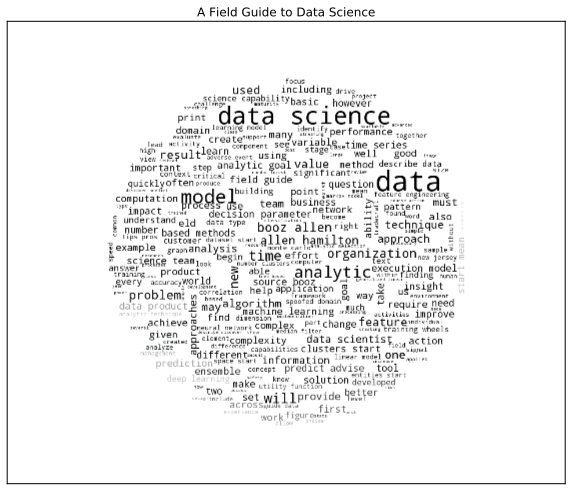

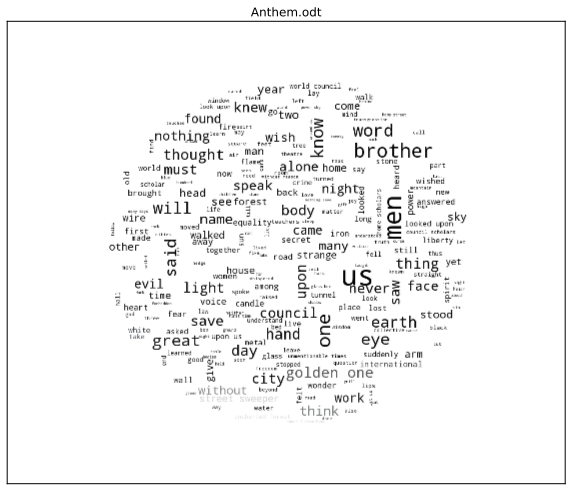

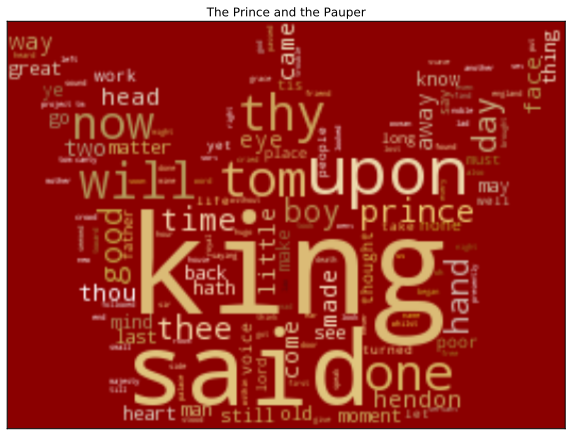

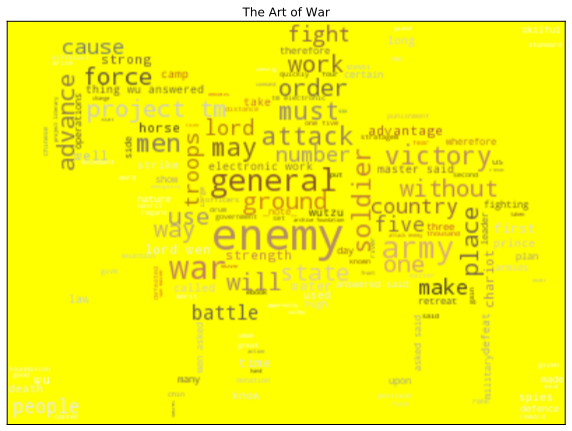

In [7]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

##
## draw a word cloud for a supplied text "corpus" -- options include range of text
## sizes, color schemes, shape masks, numbers of words to use. the default were 
## chosen to give good results for most documents...
##

def draw_word_cloud(corpus, 
                    img_title='wc',
                    img_file='outputs/images/wc.png',
                    img_bgd='white',
                    img_mask='outputs/images/bwoval.png', 
                    num_words=50,
                    use_title=True,
                    display=DISPLAY_IMAGES,
                    save_image=True,
                    max_font=50):
    # there's a global defined here...
    stopwords = set(STOPWORDS)
    # the mask that we'll use in representing the word cloud...
    the_mask = np.array(Image.open(img_mask))
    # title for the figure
    the_title = img_title
    # okay so do it...
    wc = WordCloud(background_color=img_bgd,
                   stopwords=stopwords,
                   mask=the_mask,
                   max_font_size=max_font,
                   max_words=num_words).generate(corpus)
    image_colors = ImageColorGenerator(the_mask)
    fig = plt.figure(figsize=(10,10))
    plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    if (use_title == True):
        plt.title(("%s" % img_title))
    else:
        print("Created word cloud for %s" % img_title)
    if (save_image == True):
        plt.savefig(img_file)
    if (display == True):
        plt.show()
    else:
        plt.close()
    return

##
## block of code that loops over the documents that we've stored 
## in our documents dictionary and draws word clouds for them...
##

for this_file in docs.keys():
    (contents, lines, words, wftab, metrics) = docs[this_file]
    # generate a concatenated list of all of the words in the document (with spaces added)...
    corpus = ""
    for word in words:
        corpus += ("%s " % word)
    title = this_file.replace('.pdf','').replace('.txt','').replace('.docx','',).replace('.epub','')
    ifile = image_file(title, prefix="wc", image_dir=IMAGE_FILES)
    
    if (title == 'The Prince and the Pauper'): # deliberately treating this one differently to demonstrate other capabilities...
        draw_word_cloud(corpus, img_title=title, img_bgd='darkred', img_mask='outputs/images/rgbcrown.jpg', 
                        img_file=ifile, num_words=250, max_font=64, save_image=True)
    elif (title == 'The Art of War'): # treat this differently also...
        draw_word_cloud(corpus, img_title=title, img_bgd='yellow', img_mask='outputs/images/rgbhorse.jpg', 
                        img_file=ifile, num_words=250, max_font=32, save_image=True)        
    else:
        draw_word_cloud(corpus, img_title=title, img_bgd='white', img_mask='outputs/images/bwoval.png', 
                        img_file=ifile, num_words=250, max_font=64, save_image=True)     

You can have a lot of fun using different colored masks and fonts and shapes.  Next we turn to computing another sort of thing that you'll do a lot:  word histograms.

### 2.2 Word Histograms

We computed word frequency tables when we were computing document statistics in the previous stage. Let's show histograms of the most frequently occuring words in the documents.

Creating histogram...


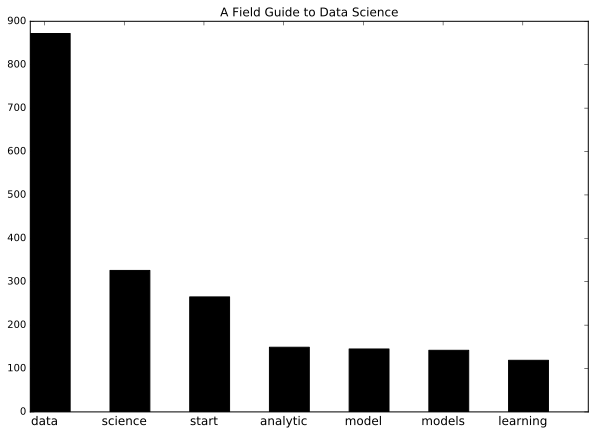

Creating histogram...


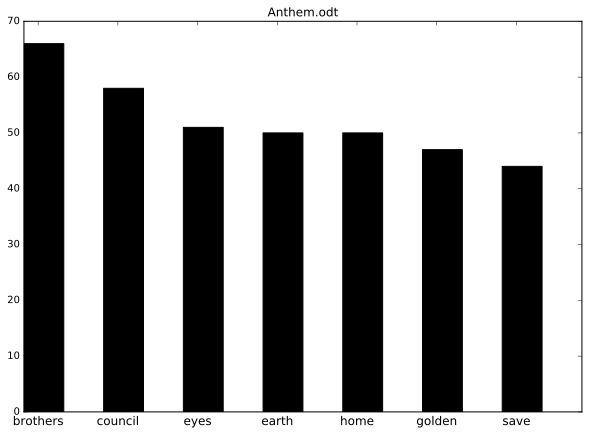

Creating histogram...


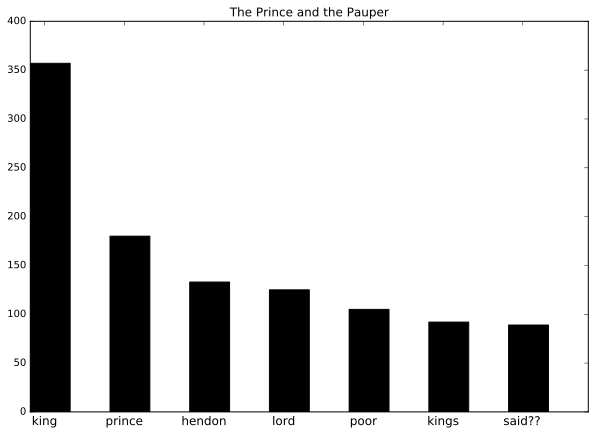

Creating histogram...


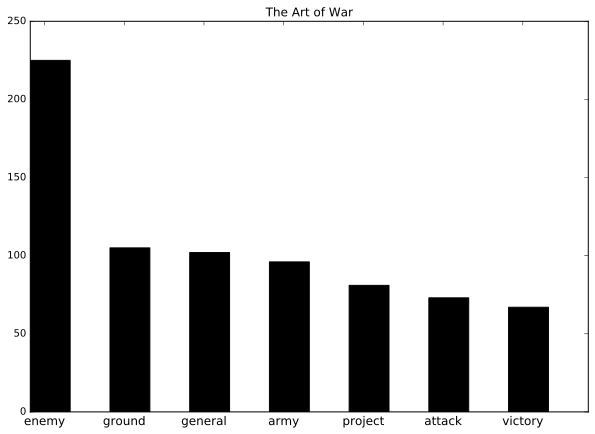

In [8]:
## a list of words that are generally not going to be of interest but that occur quite frequently
## lists like this are of course specific to particular languages and very often to particular 
## subjects or contents...

def drop_word(w):
    drop_list = ['their','theirs','which','would','should','could','there','about','much', 'thir',
                 'these','those','other','first','second','third','fourth','fifth','however',
                 'sixth','seventh','eighth','ninth','tenth','again','right','might','therefore',
                 'little','thing','things','where','great','small','along','every','don\'t','won\'t',
                 'couldnt','didnt','under','another','above','enough','without','nothing','whom'
                 'while','coming','going','doing','making','putting','one','two','three','work',
                 'four','five','six','seven','eight','nine','ten','themselves','himself','time',
                 'hundred','hundreds','dozen','dozens','shall','around','thousands','millions',
                 'billion','billions','herself','never','always','forever','whenever','whichever',
                 'before','after','thousand','million','myself','being','through','througout',
                 'place','still','that','with','this','they','have','were','then','said','them',
                 'ours','them','from','when','what','than','some', 'will','good','your','well',
                 'been','into','onto','down','upon','within','like','made','know','more','came',
                 'only','just','come','away','even','over','make','here','such','very','must',
                 'went','take','took','ever','back','mind','most','thou','thee','thine','mine',
                 'thus','thy']
    if (w in drop_list) or ('[' in w) or ('/' in w) or (w.isnumeric() == True):
        return True
    return False

##
## simple function for drawing a word histogram for a supplied document
##

def draw_word_histogram(docs_name, docs_entry, max_words=7, min_word_length=3, 
                        bar_color='black', save_image=True, verbose=True, display=DISPLAY_IMAGES):
    '''
    '''
    (_,_,_,wft,_) = docs_entry
    raw_words = [ word for (word,_) in wft[0:200]]
    raw_freqs = [ freq for (_,freq) in wft[0:200]]
    words = []
    freqs = []
    cnt = 0
    for i in range(0,len(raw_words)):
        if ((len(raw_words[i]) > min_word_length) 
            and (drop_word(raw_words[i]) == False) 
            and ('â' not in raw_words[i]) # problem character that gutenberg epubs seem to propagate...
            ):
            cnt += 1
            words.append(raw_words[i])
            freqs.append(raw_freqs[i])
            
    words = words[0:max_words]
    freqs = freqs[0:max_words]
    indices = np.arange(len(words))
    scale = 5.0 / float(max_words)
    width = 0.7 * scale
    fig = plt.figure(figsize=(10,7))
    plt.bar(indices, freqs, width, color=bar_color)
    plt.xticks(indices + width * 0.5 * scale, words, size=12)
    title = docs_name.replace('.txt','').replace('.docx','').replace('.pdf','').replace('.epub','')
    plt.title(("%s" % title))
    if (save_image == True):
        plt.savefig(image_file(title, prefix='wh', image_dir=IMAGE_FILES))
    if (display == True):
        plt.show()
    else:
        plt.close()
    return

##
## loop over the documents in our archive and draw the histograms...
##

for entry in docs.keys():
    print("Creating histogram...")
    draw_word_histogram(entry, docs[entry], display=DISPLAY_IMAGES)
print("")

One thing you might have noticed is that the histograms don't necessarily show exactly the same emphasis that the word clouds do.  That was by intent -- the word clouds were generated using the full, raw documents.  The histograms have a bit of finessing added.  For example we're excluding common grammatical "glue" words and lots of very short words. 

### 2.3 Document Parsing and Annotation

Performing sentiment analysis is a two phase process.  

The first part uses the Stanford Core NLP engine to analyze and annotate the document focusing on elements related to sentiment. You can download the engine from the Stanford website https://stanfordnlp.github.io/CoreNLP/ and then just follow directions to install it. The current version is version 3.8 though I'm only using version 3.7 in this example.  It's a pretty big download -- about 500 MB for the base engine -- the system comes with language models for English, but there are also models available for Mandarin, Spanish, Arabic, German, and French. It's a very impressive package with all sorts of capabilities.  We're just going to focus on the 'sentiment' annotation aspects of it here.

If you have a high-end server with something like 48 cores and 256 GB of ram or something then you can zoom through several dozen documents <i>at the same time</i>, but with a laptop or more modest desktop you'll probably have to do things sequentially.  In order to save time in the presentation, I've gone ahead and pre-annotated the documents that we're working with -- as you can see:

In [9]:
##
## uses the Stanford CoreNLP toolkit to perform a sentiment analysis on a document
## am invoking this via shell script and batch processing. could also be invoked by
## using the package corenlp_pywrap and making direct API calls.
##
def corenlp_annotator(input_file,
                      memory="8g", 
                      inputs=TXT_OUTPUTS, 
                      outputs=JSON_OUTPUTS, 
                      verbose=False):
    output_file = ("%s/%s" % (outputs, input_file.replace('.txt','.json')))
    #print("looking for existence of \'%s\'" % output_file)
    ## only do work here if we have not already processed the file...
    if (os.path.exists(output_file) == False):
        beg_t = time.time()
        scripts_dir = CORENLP_HOME
        nlp_program = "edu.stanford.nlp.pipeline.StanfordCoreNLP"
        misc0 = ("java -Xmx%s -cp \"%s/*\" %s" % (memory, scripts_dir, nlp_program))
        annotators = "tokenize,ssplit,pos,parse,sentiment"
        misc1 = ("-annotators \"%s\"" % annotators)
        misc2 = ("-outputFormat json -replaceExtension -file %s/%s -outputDirectory %s" % 
                    (inputs, input_file, outputs))
        cmd_line = ("%s %s %s" % (misc0, misc1, misc2))
        if (verbose == True):
            print("cmd_line:\n%s" % cmd_line)
        status = os.system(cmd_line)
        if (status == 256):
            print("\tCoreNLP: document \'%s\' not found!!!" % input_file)
        elif (status != 0):
            print("\tCoreNLP: non-zero results code = %d when processing \'%s\'" % (status, input_file))
        end_t = time.time()
        print("\tCoreNLP annotation for \"%s\" required %.2f secs" % (input_file, (end_t - beg_t)))
    else:
        print("\tCoreNLP annotation for \"%s\" has already been done." % input_file)
    return
##
## loop over the documents in our archive and process them.
##
for doc in sorted(list(docs.keys())):
    corenlp_annotator(("%s" % doc), memory="8g")

	CoreNLP annotation for "A Field Guide to Data Science.pdf.txt" has already been done.
	CoreNLP annotation for "Anthem.odt.txt" has already been done.
	CoreNLP annotation for "The Art of War.docx.txt" has already been done.
	CoreNLP annotation for "The Prince and the Pauper.epub.txt" has already been done.


My laptop is pretty representative of a normal geek's (is that an oxymoron?) home computer (an 8-core 2.6(3.6)GHz CoreI7-4720HQ with 16 GB RAM).  I'm running Linux (Centos 7.3) and have Anaconda python loaded with everything I could find related to data science, visualization, computer vision, and machine learning.  Here are how long the documents took to process using <i>memory="8gb"</i>:

        Document                         Total
        ------------------              -------
        The Prince and The Pauper       694.7s
        A Field Guide to Data Science   671.8s
        The Art Of War                  271.2s
        Anthem                           67.1s

The output of the CoreNLP processing was a set of JSON files that we will be using for the next phase of the analysis.

In [10]:
print("\t%s contains..." % JSON_OUTPUTS)
cnt = 0
for file in os.listdir(JSON_OUTPUTS):
    cnt += 1
    print("\t[%d] %s" % (cnt,file))

	outputs/json contains...
	[1] A Field Guide to Data Science.pdf.json
	[2] Anthem.odt.json
	[3] The Art of War.docx.json
	[4] The Prince and the Pauper.epub.json


### 2.4 Sentiment Analysis

Now the second phase of the sentiment analysis process actually just involves walking through the results of the CoreNLP evaluation and making sense of it.  It runs very quickly in comparison and typically only a few seconds per document. 

In [11]:
def get_relationships(sents, key_word):
    connections = []
    for i in range(len(sents)):
        words = [token['word'].lower() for token in sents[i]['tokens']]
        if key_word in words:
            for k in sents[i]['basicDependencies']:
                if (('governorGloss' in k.keys()) and ('dependentGloss' in k.keys())):
                    governor = k['governorGloss'].lower()
                    dependent = k['dependentGloss'].lower()
                    if (((governor.lower() == key_word) or (dependent.lower() == key_word)) and
                        (governor.lower() != '•' and dependent.lower() != '•') and
                        (('compound' in k['dep']) or ('compound' in k['dep']) or 
                         ('mod' in k['dep']) or ('conj' in k['dep'])) and
                         (k['dep'] != 'nmod:poss')):
                        connections.append(sorted([governor.lower(), dependent.lower()]))
    d = {}
    entries = [c for c in connections]
    for e in entries:
        name = ' '.join(e)
        if name in d:
            d[name] += 1
        else:
            d[name] = 1
    edges = []
    for k in d:
        edges.append([k, d[k]])
    sorted_edges = sorted(edges, key=lambda b: -b[1])[0:20]
    return sorted_edges, entries

##
## walk through the json file, grab sentences
##

def compute_sentiments(json_file, number=10, verbose=False):
    beg_t = time.time()
    print("\n\tProcessing \'%s\' ..." % json_file)

    with open(json_file) as jfile:
        json_data = json.load(jfile)  

    ## all sentences...
    sentences = json_data['sentences']
    keyword = 'data'
    sorted_entries, entries = get_relationships(sentences, keyword)
    
    ## pull out the negative and positive sentences from the collection of sentences...
    negpos_sents = {}
    for i in range(len(sentences)):
        words = [token['word'].lower() for token in sentences[i]['tokens']]
        #if ('data' in words):                                                                                              
        sentiment = sentences[i]['sentiment']
        if sentiment not in negpos_sents.keys():
           negpos_sents[sentiment] = [' '.join(words)]
        else:
           negpos_sents[sentiment].append(' '.join(words))

    ## some basic counting...
    n_sen  = 0
    n_neg  = 0
    n_pos  = 0
    n_vneg = 0
    n_vpos = 0
    n_neu  = 0
    for k in negpos_sents.keys():
        n_sen += len(negpos_sents[k])
        if (k == "Neutral"):
            n_neu += 1
        elif (k == "Verynegative"):
            n_vneg += 1
        elif (k == "Negative"):
            n_neg += 1
        elif (k == "Verypositive"):
            n_vpos += 1
        else:
            n_pos += 1
        print("\t%s: %s" % (k, len(negpos_sents[k])))
    print("\tRanked: %d" % n_sen)
    
    ## very negative sentiments...
    vneg_sents = []
    if ('Verynegative' in negpos_sents.keys()):
        for s in negpos_sents['Verynegative']:
            vneg_sents.append(re.sub('[^a-zA-Z ]', '', s))
        #print("\tafter 'Verynegative' -- len(neg_sents) = %d" % len(neg_sents))
    ## negative sentiments...
    neg_sents = []
    if ('Negative' in negpos_sents.keys()):
        for s in negpos_sents['Negative']:
            neg_sents.append(re.sub('[^a-zA-Z ]', '', s))
        #print("\tafter 'Negative' -- len(neg_sents) = %d" % len(neg_sents))
    if (len(vneg_sents) > 0):
        vneg_sents = [s.replace('rsb', ''
                      ).replace('lsb', ''
                      ).replace('lrb', ''
                      ).replace('rrb', ''
                      ) for s in vneg_sents]
    if (len(neg_sents) > 0):
        neg_sents = [s.replace('rsb', ''
                     ).replace('lsb', ''
                     ).replace('lrb', ''
                     ).replace('rrb', ''
                     ) for s in neg_sents]
    
    ## verypositive sentiments...
    vpos_sents = []
    if ('Verypositive' in negpos_sents.keys()):
        for s in negpos_sents['Verypositive']:
            vpos_sents.append(re.sub('[^a-zA-Z ]', '', s))
        #print("\tafter 'Verypositive' -- len(pos_sents) = %d" % len(pos_sents))
    ## positive sentiments...
    pos_sents = []
    if ('Positive' in negpos_sents.keys()):
        for s in negpos_sents['Positive']:
            pos_sents.append(re.sub('[^a-zA-Z ]', '', s))
        #print("\tafter 'Positive' -- len(pos_sents) = %d" % len(pos_sents))

    ## a bit of cleanup
    if (len(vpos_sents) > 0):
        vpos_sents = [s.replace('rsb', ''
                      ).replace('lsb', ''
                      ).replace('lrb', ''
                      ).replace('rrb', ''
                      ) for s in vpos_sents]
    if (len(pos_sents) > 0):
        pos_sents = [s.replace('rsb', ''
                     ).replace('lsb', ''
                     ).replace('lrb', ''
                     ).replace('rrb', ''
                     ) for s in pos_sents]
    if (verbose == True):
        for i in range(0,min(len(vneg_sents), number)):
            print("\tVeryNegative: %d. \'%s\'" % (i+1,vneg_sents[i]))
        for i in range(0,min(len(neg_sents), number)):
            print("\tNegative: %d. \'%s\'" % (i+1,neg_sents[i]))
        for i in range(0,min(len(vpos_sents), number)):
            print("\tVeryPositive: %d. \'%s\'" % (i+1,vpos_sents[i]))
        for i in range(0,min(len(pos_sents), number)):
            print("\tPositive: %d. \'%s\'" % (i+1,pos_sents[i]))
    end_t = time.time()
    print("\tProcessing required %.2fs" % (end_t - beg_t))
    return vpos_sents, pos_sents, vneg_sents, neg_sents, n_sen, n_neu, n_pos, n_neg, n_vpos, n_vneg
    
##
## finally, loop over the documents we have in hand...
##

if (os.path.exists(("%s/%s" % (PICKLE_FILES, 'sens.pkl'))) == True):
    sentiments = pickle.load(open(("%s/%s" % (PICKLE_FILES, 'sens.pkl')),'rb'))
else:
    sentiments = {}
    
for file in os.listdir(JSON_OUTPUTS):
    json_file = ("%s/%s" % (JSON_OUTPUTS,file))
    sentiments[file] = compute_sentiments(json_file, number=10)
    pickle.dump(sentiments,open(("%s/%s" % (PICKLE_FILES, 'sens.pkl')),'wb'))
    


	Processing 'outputs/json/A Field Guide to Data Science.pdf.json' ...
	Positive: 320
	Negative: 1143
	Verynegative: 33
	Verypositive: 8
	Neutral: 377
	Ranked: 1881
	Processing required 0.37s

	Processing 'outputs/json/Anthem.odt.json' ...
	Positive: 253
	Negative: 687
	Verynegative: 13
	Verypositive: 7
	Neutral: 298
	Ranked: 1258
	Processing required 0.27s

	Processing 'outputs/json/The Art of War.docx.json' ...
	Positive: 164
	Negative: 671
	Verynegative: 34
	Verypositive: 4
	Neutral: 156
	Ranked: 1029
	Processing required 0.26s

	Processing 'outputs/json/The Prince and the Pauper.epub.json' ...
	Positive: 669
	Negative: 1910
	Verynegative: 203
	Verypositive: 27
	Neutral: 853
	Ranked: 3662
	Processing required 0.81s


The times you saw above though are slightly better than real time.  Just as before, I've run these calculations in advance and stored the processed sentiments information in pickle archive (this time
the archive is called 'sens.pkl').  The real times required to compute the sentiments information for the various files were:

            Document                        Time
            ----------------------------    -----
            The Prince and The Pauper       0.90s
            A Field Guide to Data Science   0.39s
            The Art of War                  0.23s
            Anthem                          0.19s

I am NOT going to print out the exhaustive lists of the results from the sentiment analysis.  As you can see above there are LOTS of ranked sentences for each document.  Just to give you a feel for the sorts of things that you get, here are the first few sentences in the various categories in Mark Twain's The Prince and The Pauper:

In [12]:
(vpos,vneg,pos,neg,_,_,_,_,_,_) = sentiments['The Art of War.docx.json']
print("\nVeryPositive:")
for i in range(0,3):
    print("\n[%d] \'%s\'" % (i, vpos[i]))

print("\nVeryNegative:")
for i in range(0,3):
    print("\n[%d] \'%s\'" % (i, vneg[i]))

print("\nPositive:")
for i in range(0,3):
    print("\n[%d] \'%s\'" % (i, pos[i]))

print("\nNegative:")
for i in range(0,3):
    print("\n[%d] \'%s\'" % (i, neg[i]))
    


VeryPositive:

[0] 'belief in the importance of a knowledge of the enemy and his resources  of preparation and training  had grown out of a long study of these ancient masters  and since it was the vital importance of a successful issue to the japanese which  after all  fired their resolution and carried them through  they proved the sage s words that it is the energy  born of despair  that wins the victory '

[1] 'wherefore  intelligent rulers and wise generals use the cleverest men as spies  and invariably acquire great merit '

[2] ' the nature of chin is strong  the country rugged  and the government firm  rewards and punishments just  the people indomitable  and all have the fighting spirit  wherefore  when separated  each fights of his own accord '

VeryNegative:

[0] 'personal ambition and intrigue  and not the wishes of the people  were the main factors in these wars '

[1] 'instead of these  what may be called the force of despair is pointed out as the most powerful agent in 

Obviously these results aren't wonderful.   Sentiment analysis is still a temperamental thing and there are usually many sentences that the sentiment analyzer will have little or no opinion about or be confused about. If you are willing to very aggressively build lists of junk words to be discarded and preprocess sentences you can significantly improve the results.  Even so, the analyzer doesn't do very well with double negatives and very complex speech.  Something like "I am not an unfriend" would probably be interpreted as being strongly negative rather than mildly positive.  In practice one usually prints out a collection of ranked sentiments and cherry-picks the ones that seem to make sense by hand. Not wonderful, but that's really about what the state of the art is -- you have to tinker with it still.

### 2.5 Word Networks / Word Connections

It's often very interesting to understand how often certain combinations of words occur in close association. In this section, we'll show the most important (pair-wise) associations key terms in the documents.  The figures use indicate the relative frequency with which the nodes themselves occur as well as how often the are directly coupled. 

In [13]:
## T/F if this is a number...
def is_number(n):
    try:
        float(n)
        return True
    except ValueError:
        return False

## rough filtering of sentences...
def filter_sentences(sentences, wnl, disconsider_words):
    n_sents = len(sentences)
    joined_sentences = []
    for idx in range(n_sents):
        tokens = nltk.word_tokenize(sentences[idx])
        tagged_tokens = nltk.pos_tag(tokens)
        tagged_tokens = [tagged_token for tagged_token in tagged_tokens if not is_number(tagged_token[0])
                  and tagged_token[0] not in ENGLISH_STOP_WORDS and len(tagged_token[0]) > 2 and
                         tagged_token[0].lower() not in disconsider_words]

        filtered_words = []
        for token in tagged_tokens:
            if token[1].startswith('N'):
                filtered_words.append(wnl.lemmatize(token[0], 'n'))
            elif token[1].startswith('V'):
                filtered_words.append(wnl.lemmatize(token[0], 'v'))
            else:
                filtered_words.append(token[0])

        sentences[idx] = filtered_words
        joined_sentences.append(' '.join(filtered_words))
    return joined_sentences

## locate ngrams
def find_ngrams(content_words, n, n_ngrams, min_examples=5):
    files_ngrams = {}
    files_cleaned_text = {}

    split_text = []
    for sents in content_words:
        split_text += sents
    ngrams = get_ngrams(split_text, n, min_examples, n_ngrams)
    if len(ngrams) == 0:
        ngrams = get_ngrams(split_text, 2, min_examples, n_ngrams)
    return ngrams, ' '.join(split_text)

## count the ngrams
def count_common_ngrams(files_ngrams):
    ngrams = {}

    for file_name in files_ngrams:
        file_ngrams = files_ngrams[file_name]
        for ngram_freq in file_ngrams:
            ngram = ', '.join(sorted(list(set(ngram_freq[0]))))
            if ngram in ngrams:
                ngrams[ngram] += [file_name]
            else:
                ngrams[ngram] = [file_name]
    ngrams_sorted = []
    for k in ngrams:
        ngrams_sorted.append([k, len(ngrams[k])])
    ngrams_sorted = sorted(ngrams_sorted, key=lambda g: -g[1])
    return ngrams, ngrams_sorted

## collect the ngrams
def get_ngrams(text, n_gram, freq_filter, top_n):
    finder = None
    ngram_measure = None

    if n_gram == 2:
        ngram_measure = nltk.collocations.BigramAssocMeasures()
        finder = BigramCollocationFinder.from_words(text)

    elif n_gram == 3:
        ngram_measure = nltk.collocations.TrigramAssocMeasures()
        finder = TrigramCollocationFinder.from_words(text)

    finder.apply_freq_filter(freq_filter)
    #ngrams = finder.nbest(ngram_measure.likelihood_ratio, top_n)                                      
    ngrams = sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:top_n]
    return ngrams

## in verbose mode, supply some information..                                                                                                  
def print_node_info(results, key, max_nodes=7, from_nodes=False, to_nodes=False, verbose=False):
    '''                                                                                                
    '''
    (fromX, toX) = results[key]
    if (from_nodes == True) and (verbose == True):
        print("from \'%s\' to X:\n" % key)
        for (w1,c1,c0,w2,c2) in fromX[0:max_nodes]:
            print("\t\'%s\' (%d) ------ %d ------ \'%s\' (%d)" % (w1,c1,c0,w2,c2))
    if (to_nodes == True) and (verbose == True):
        print("to X from \'%s\':\n" % key)
        for (w1,c1,c0,w2,c2) in toX[0:max_nodes]:
            print("\t\'%s\' (%d) ------ %d ------ \'%s\' (%d)" % (w1,c1,c0,w2,c2))
    return

## do the conversion from text to vector space...                                                                                                                                                                                                                           
def vectorize_text(text_matrix, n_max_features):
    vectorizer = TfidfVectorizer(max_df=1.0, max_features=n_max_features,
                                 min_df=1,stop_words='english',
                                 use_idf=False)
    vectorizer = vectorizer.fit(text_matrix)
    X = vectorizer.transform(text_matrix).toarray().astype(np.float16)

    return X, vectorizer

## This function (in full form) uses TfifdVectorization, TruncatedLSA, and Google Pagerank
## to compute the most important sentences in a document. In addition to sentences it also
## estimates the most important words (from a semantic standpoint) as well as the most important
## pairs (2-grams) of words.  It can be very slow for large documents because many of the 
## component pieces run O(n^3).  
##
## We'll reuse this function later in its full form. For getting important words and ngrams
## it's sufficient to set skip_sentence=True (which avoids most of the work)...
def compute_importance(txtfile,
                       ftarget=0.95,
                       niwords=100,
                       n2grams=100,
                       vsdmin=10,
                       verbose=True,
                       min_examples=5,
                       skip_sentences=False):           
    with open(txtfile) as f_handle:
        this_document = f_handle.read().replace('-\n', ''
                                      ).replace('\n', ' '
                                      ).replace('•', '.'
                                      ).lower()
    wnl = WordNetLemmatizer()
    raw_sentences = nltk.sent_tokenize(this_document)
    filtered_sentences = raw_sentences.copy()
    sentences = filter_sentences(filtered_sentences, 
                                 wnl, 
                                 ['this', 'the', 'reassessment', 'online', 
                                  'strategic', 'http', 'what', 'why', 
                                  'accomplish', 'executive'])
    ngrams, cleaned_text = find_ngrams(filtered_sentences, 2, n2grams, min_examples=min_examples)

    if (verbose == True):
        print("\tImportant 2-Grams:")
    count = 1
    for ((one,two),num) in ngrams[0:10]:
        if (verbose == True):
            print("\t\t%.3d:  %s -- %s (%d)" % (count, one, two, num))
        count += 1
    top_n_words = niwords
    cv = CountVectorizer()
    cv_fit = cv.fit_transform(sentences)
    high_freq_words = sorted(list(zip(cv.get_feature_names(), 
                                      np.sum(cv_fit.toarray(), axis=0))), 
                             key=lambda w:-w[1])[0:top_n_words]
    if (verbose == True):
        print("\tImportant Words:")
    count = 1
    for word in high_freq_words[0:10]:
        if (verbose == True):
            print("\t\t%.3d: %s (%d)" % (count, word[0], word[1]))
        count += 1
    original_sentences = copy.deepcopy(raw_sentences) 
    # raw_sentences can be entered here (see NLTK sentence tokenizer)                                              
    sentences = copy.copy(original_sentences)
    filtered_sentences = filter_sentences(sentences, 
                                          wnl, 
                                          ['this', 'the', 'reassessment', 'online', 
                                           'strategic', 'http', 'what', 'why', 'accomplish'])
    if (skip_sentences == True):
        vsd = vsdmin
        important_sentences = []
    else:
        nfs = len(filtered_sentences)
        print("\tNumber of filtered_sentences = %d" % nfs)
        # the following runtime estimate is based on the statistics from the timing numbers                                                                          
        # for the first 42 models that were calculated -- it tends to OVER estimate the                                                                              
        # time by 2 to 3x for very short documents (nfs < 100) but does very well for                                                                                
        # longer documents (nfs > 500)...                                                                                                                            
        eta = 2.208e-7 * nfs**3 + 1.690e-5 * nfs**2 - 0.0091 * nfs + 0.591
        print("\tEstimated upper limit on LSA calculation = %10.2f seconds" % eta)
        X, vect = vectorize_text(filtered_sentences, 4000) # 4000 features seems rather excessive...                                                                 
        upper_bound = math.floor(X.shape[1]/2)
        print("\tUpper Bound = %d" % upper_bound)
        print("\tVS Dim Min  = %d" % vsdmin)
        print("\tDefining vector space...")
        # The vector space can be anywhere from vsdmin to numwords dimensions. The computational 
        # burden rises extremely sharply with this dimensionality.  Smaller numbers are therefore 
        # prefered if possible. for 512 sentences 100 is good, for 2000 sentences even 500 is too small...                                                                                 
        start_time = time.time()
        for n_comp in range(vsdmin, upper_bound):
            tsvd = TruncatedSVD(n_components=n_comp)
            tsvd.fit(X)
            if (verbose == True):
                if (n_comp % 100 == 0):
                    print("\tn_comp: %d, fraction explained = %6.3f" % 
                          (n_comp, np.sum(tsvd.explained_variance_ratio_)))
            if (np.sum(tsvd.explained_variance_ratio_) >= ftarget):
                X_trans = tsvd.transform(X)
                print('\tVector Space of dimension %d accounts for %6.3f of the variance' % 
                      (n_comp, ftarget))
                break
        print("\tThe LSA calculation (TruncatedSVD) for VSD required %9.3f sec" % (time.time() - start_time))
        vsd = n_comp
        print("\tX_trans shape: ",X_trans.shape)
        print("\tGraph calculation...")
        cosine_sim_mat = cosine_similarity(X_trans)
        gr = nx.Graph()
        sents_added = {}
        start_time = time.time()
        for r_idx in range(0, cosine_sim_mat.shape[0]):
            offset = 1
            if (original_sentences[r_idx] not in sents_added):
                gr.add_nodes_from(original_sentences[r_idx])
                sents_added[original_sentences[r_idx]] = 1
            idxs = np.where(cosine_sim_mat[r_idx:] >= 0.1)[0]
            for c_idx in idxs[:-1]:
                if (original_sentences[c_idx] not in sents_added):
                    gr.add_nodes_from(original_sentences[c_idx])
                    sents_added[original_sentences[c_idx]] = 1
                cos_sim = cosine_sim_mat[r_idx][c_idx]
                n_words = len(original_sentences[r_idx].split())
                gr.add_edge(original_sentences[r_idx], original_sentences[c_idx], weight=cos_sim)
        print("\tThe graph calculation (used as inputs for pagerank) required %9.3f sec" % 
              (time.time() - start_time))
        # this takes a very long time for large dimensionality -- it's O(N**3)                                                                                       
        start_time = time.time()
        print('\tComputing pagerank')
        calculated_page_rank = nx.pagerank(gr, weight='weight', alpha=0.85, max_iter=1000, tol=1.0e-4) 
                                                # defaults: max_iter=100, tol=1.0e-6, alpha=0.85               
        sentences = sorted(calculated_page_rank, key=calculated_page_rank.get, reverse=True)
        print("\tThe pagerank calculation itself required %9.3f sec" % (time.time() - start_time))
        count = 0
        important_sentences = []
        if (verbose == True):
            print('\tImportant Sentences:')
        for sent in sentences[0:10]:
            important_sentence = sent.replace('\n', ' '
                                    ).replace('     ',' '
                                    ).replace('    ',' '
                                    ).replace('   ',' '
                                    ).replace('  ',' '
                                    ).strip()
            if (verbose == True):
                print("\t\t",important_sentence)
            important_sentences.append(important_sentence)
        # now ship everything back...                                                                                                                                
    return important_sentences, ngrams, high_freq_words, vsd

##  Compute word connections based on importance -- but allow users to override the
##  actual importance and put in keywords that they feel ought to have special relevance
##  as well.  Please keep the list of those 'extra_words' very short.  Also the default
##  values for niwords and n2grams may need to be set to very high values to allow for
##  building connection diagrams that actually have as many members as the default.
##
##  I'm NOT checking here to make sure that you actually have enough words to match
##  niwords for example so it's possible to break things by being too ambitious. If
##  you have a short document, I'd suggest trying a much smaller niwords/n2grams...
def compute_connections(docfile, extra_words=['awareness'], niwords=5000, n2grams=5000,
                        target_base=2, txtdir=TXT_OUTPUTS, verbose=False):
    beg_t = time.time()
    if (os.path.exists(("%s/%s" % (PICKLE_FILES,'conn.pkl'))) == True):
        conn = pickle.load(open(("%s/%s" % (PICKLE_FILES,'conn.pkl')),'rb'))
    else:
        conn = {}

    if (len(conn) == 0) or (docfile not in conn.keys()):
        # construct the target file...                                                                                                                            
        txtfile = ("%s/%s" % (txtdir,docfile))
        # run partial computation with larger lists of words and digrams...                                                                                       
        (_,dgm,wrd,_) = compute_importance(txtfile,
                                           niwords=niwords, 
                                           n2grams=n2grams,
                                           verbose=False,
                                           min_examples=2,
                                           skip_sentences=True)
        # create a proper word frequency table from 'wrd'...                                                                                                      
        wdfreqs = {}
        for (word,freq) in wrd:
            wdfreqs[word] = freq
        keywords = wdfreqs.keys()
        # define target list as the 'target_base' most important words and anything else the user might                                                           
        # have supplied with 'extra_words'...                                                                                                                     
        targets = [ word for (word,_) in wrd[0:target_base] ]
        if (len(extra_words) != 0):
            for extra in extra_words:
                targets.append(extra)
        # now for each of the members in the target list we want to compute the dumbell information                                                               
        working = {}
        for target in targets:
            pairs = []
            for ((w1,w2),cnt) in dgm:
                if (w1 != w2):
                    if ((w1 in keywords) and (w2 in keywords)):
                        if (target == w1):
                            pairs.append(((target, wdfreqs[target]), (w2, wdfreqs[w2]), cnt))
                        elif (target == w2):
                            pairs.append(((w1, wdfreqs[w1]), (target, wdfreqs[target]), cnt))
            working[target] = sorted(pairs, key=itemgetter(2), reverse=True)
        # now collate the information...
        results = {}
        for key in working.keys():
            if (drop_word(key) == False):
                from_node = []
                to_node = []
                for item in working[key]:
                    ((w1,c1),(w2,c2),c3) = item
                    if (w1 == key) and drop_word(w1) == False:
                        from_node.append((w1,c1,c3,w2,c2))
                    if (w2 == key) and drop_word(w2) == False:
                        to_node.append((w1,c1,c3,w2,c2))
                results[key] = (from_node, to_node)
        # only update this if it's a brand new conn or we haven't done added this document yet...
        conn[docfile] = results
        pickle.dump(conn, open(("%s/%s" % (PICKLE_FILES, 'conn.pkl')),'wb'))
    else:
        conn = pickle.load(open(("%s/%s" % (PICKLE_FILES, 'conn.pkl')),'rb'))
    if (verbose == True):
        sample = conn[docfile]
        print("{%s}:" % docfile)
        for key in sample.keys():
            print_node_info(sample, key, max_nodes=7, from_nodes=True, to_nodes=False, verbose=True)
    end_t = time.time()
    print("\tComputing connections for {%s} required %.2fs" % 
          (docfile.replace('.txt','').replace('.epub','').replace('.docx','').replace('.pdf',''),
           (end_t - beg_t)))
    return conn
##
## populate the connections dictionary...
##
for doc in docs.keys():
    raw_name = ("%s" % doc)
    conn = compute_connections(raw_name, extra_words=[], target_base=1, niwords=500, n2grams=500)
##
## fetch the connections archive...
##
conn = pickle.load(open(("%s/%s" % (PICKLE_FILES, 'conn.pkl')),'rb'))

	Computing connections for {A Field Guide to Data Science} required 0.00s
	Computing connections for {Anthem.odt} required 0.00s
	Computing connections for {The Prince and the Pauper} required 0.00s
	Computing connections for {The Art of War} required 0.00s


Again, don't believe the instantaneous calculation times. I've prebuilt the connection object so that things could move more smoothly.  The calculations word connection really required:

        Document                         Time
        ------------------------------  ------
        The Prince and The Pauper       11.35s
        A Field Guide To Data Science    5.28s
        The Art of War                   3.15s
        Anthem                           2.45s
        
Let's draw the connections:

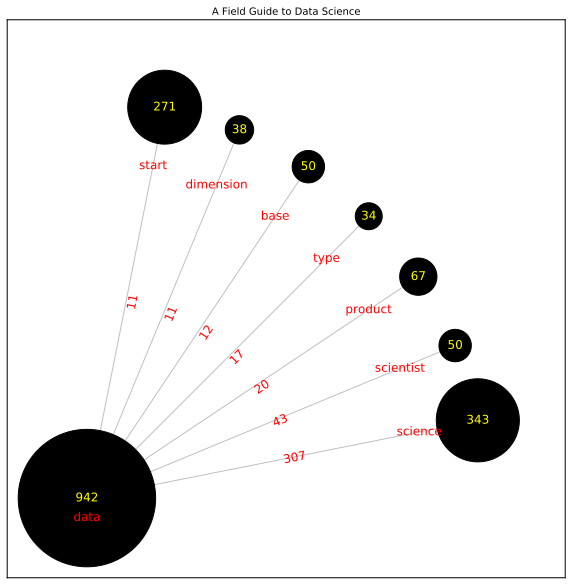

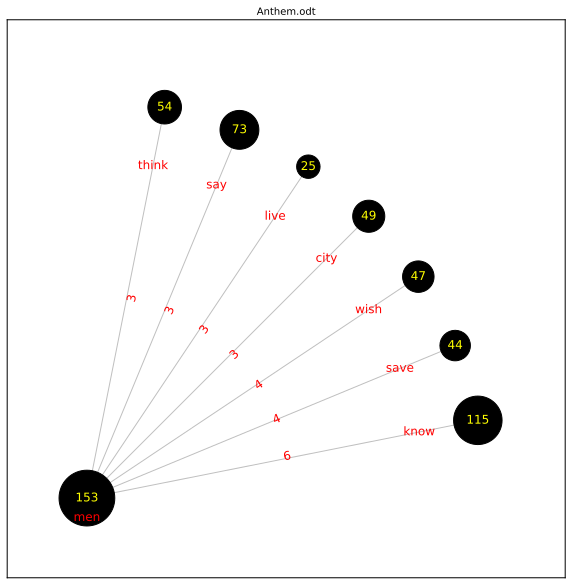

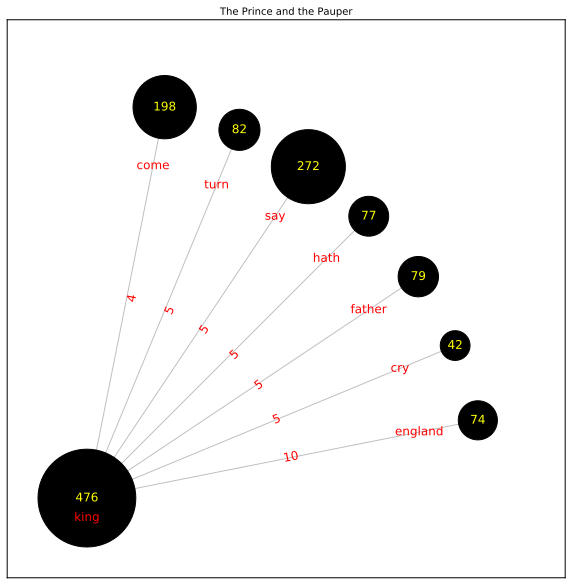

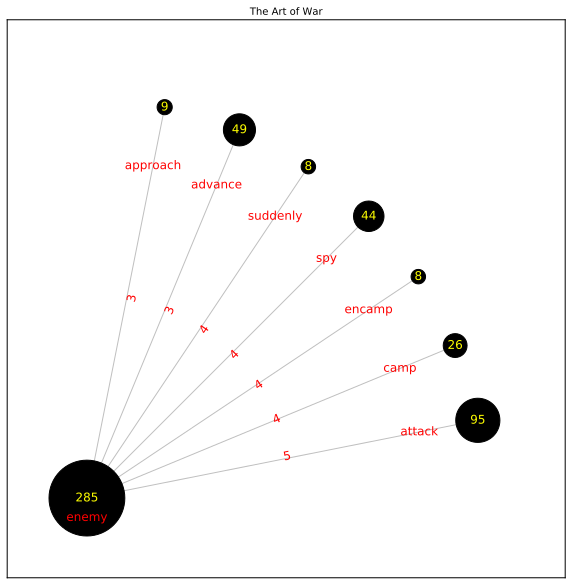

	Created images for 4 files


In [14]:
## This function renders the connection images...
def draw_connection_images(conn, blob_scale=20, min_blob_size=50, font_size=12, 
                           blob_color='black', line_color='black', line_width=1, 
                           line_alpha=0.25, label_color='yellow', text_color='red', 
                           use_title=True, display=False, save_image=True, maxpts=7):
    fcount = 0
    for name in conn.keys():
        # dictionary of results for the file \'%s\'                                                                                                                  
        results  = conn[name]
        # loop over the chosen keywords...                                                                                                                           
        for keyword in results.keys():
            # fromKey is the data FROM the keyword to other words...                                                                                                 
            (fromKey,_) = results[keyword]
            # only do this is there's something to plot...
            if (len(fromKey) > 0):
                # convert the data into something we can work with readily... 
                l1 = []; s1 = []; s0 = []; l2 = []; s2 = []
                for (w1,c1,c0,w2,c2) in fromKey[0:maxpts]:
                    l1.append(w1)
                    s1.append(c1)
                    s0.append(c0)
                    l2.append(w2)
                    s2.append(c2)
                    #print("paranoia: (%s,%d) --- %d --- (%s,%d)" % (w1,c1,c0,w2,c2))
                base_l =  l1[0]
                base_w = -s0[0]
                # initialize the lists...
                x = []; y = []; l = []; s = []; w = []; t = []
                # populate the first values...
                x.append(0.0)
                y.append(0.0)
                l.append(l1[0])
                w.append(-s0[0])
                s.append(min_blob_size + blob_scale * s1[0])
                t.append(0.0)
                # ready to compute...
                r = 10.0  # the units here are arbitrary...                                                                                                              
                for i in range(1, len(fromKey[0:maxpts])+1):
                    theta = (math.pi/2.0) * float(i)/float(len(fromKey[0:maxpts])+1)
                    t.append(theta)
                    x.append((r * math.cos(theta)))
                    y.append((r * math.sin(theta)))
                    l.append(l2[i-1])
                    w.append(s0[i-1])
                    s.append(min_blob_size + blob_scale * s2[i-1])

                # have to devolve to simpler graphics because of unpredictable geometry
                fig = plt.figure(figsize=(10,10))
            
                # draw the line segments...                                                                                                                              
                for i in range(1,len(x)):
                    plt.plot([x[0], x[i]], [y[0], y[i]], c=line_color, lw=line_width, alpha=line_alpha)

                # draw the blobs...                                                                                                                                      
                plt.scatter(x, y, s=s, c=blob_color)
            
                delta = 0.85
                beta  = 0.05
                # draw the numbers in the blobs...                                                                                                                       
                for i in range(0,len(x)):
                    if (i != 0):
                       #plt.annotate(("%d" % int(s[i]/blob_scale-min_blob_size)),
                       plt.annotate(("%d" % s2[i-1]),
                                    xy=(x[i],y[i]),
                                    va='center',
                                    ha='center',
                                    color=label_color,
                                    size=font_size)
                    else:
                       #plt.annotate(("%d" % int(s[i]/blob_scale-min_blob_size)),
                       plt.annotate(("%d" % s1[0]),
                                    xy=(x[i],y[i]),
                                    va='center',
                                    ha='center',
                                    color=label_color,
                                    size=font_size)
                # draw the labels along the lines...                                                                                                                     
                for i in range(0,len(x)):
                    if (w[i] >= 0):
                        rot_ang = 180*t[i]/math.pi
                        #print("rotation angle: %9.2f" % rot_ang)
                        plt.text(x[i]/2.0,
                                 y[i]/2.0,
                                 ("%d"%w[i]),
                                 color=text_color,
                                 size=font_size,
                                 rotation=rot_ang)
                # draw the word labels near the blobs...                                                                                                                 
                for i in range(0,len(x)):
                    if (i > 0):
                        plt.annotate(l[i],
                                     xy=(delta * x[i], delta * y[i]),
                                     va='center',
                                     ha='center',
                                     color=text_color,
                                     size=font_size)
                    else:
                        plt.annotate(l[i],
                                     xy=(0 * max(x), -beta * max(y)),
                                     va='center',
                                     ha='center',
                                     color=text_color,
                                     size=font_size)
                plt.xticks([])
                plt.yticks([])
                title = name.replace('.docx','').replace('.epub','').replace('.pdf','').replace('.txt','')
                if (use_title):
                    plt.title(("%s" %title),size=10)
                else:
                    print("%s" % name)
                if (save_image == True):
                    plt.savefig(image_file(title,prefix="wn",image_dir=IMAGE_FILES))
                if (display == True):
                    # show what we have...                                                                                                                               
                    plt.show()
                else:
                    # otherwise save it and leave...                                                                                                                     
                    plt.close()
                fcount += 1
    print("\tCreated images for %d files" % fcount)
    return

# draw the connection figures...
draw_connection_images(conn, display=DISPLAY_IMAGES)

### 2.6 Importance Analysis

Importance analysis is performed on the raw text documents. It contains several pieces (a Latent Semantic analysis calculation and a Graph analysis calculation in particular) that both scale very poorly with the size and complexity of the documents being analyzed.  Both of these algorithms scale O(N^3) in time with the number of phrases/sentences in the documents.  Some book sized document or epic poems can take hours to compute.   

To perform this analysis we return to the 'compute_importance' function from before but use the full function this time.  We could of course skip the words/ngrams calculation (we've already used the words information in creating the connection diagrams above) but honestly the few seconds spent recomputing them are lost in the noise of the full calculation so we don't bother.

In [15]:
## let's walk through our collection of documents and conduct an importance analysis...
for doc in docs.keys():
    beg_t = time.time()
    if (os.path.exists(("%s/%s" % (PICKLE_FILES, 'imps.pkl'))) == True):
        imps = pickle.load(open(("%s/%s" % (PICKLE_FILES, 'imps.pkl')),'rb'))
        if (doc not in imps.keys()):
            print("\n\'%s\':" % doc)
            print("\tAdding document to existing archive.")
            (sen, wrd, dgm, vsd) = compute_importance(('%s/%s' % (TXT_OUTPUTS,doc)), 
                                                      ftarget=0.95, 
                                                      niwords=2000, 
                                                      n2grams=2000, 
                                                      vsdmin=10, 
                                                      verbose=True)
            imps[doc] = (sen, wrd, dgm, vsd)
            pickle.dump(imps, open(("%s/%s" % (PICKLE_FILES, 'imps.pkl')),'wb'))
        else:
            (sen, wrd, dgm, vsd) = imps[doc]
    else:
        imps = {}
        # it's a new archive...
        print("\n\'%s\':" % doc)
        print("\tInitializing new archive.")
        (sen, wrd, dgm, vsd) = compute_importance(('%s/%s' % (TXT_OUTPUTS,doc)), 
                                                  ftarget=0.95, 
                                                  niwords=2000, 
                                                  n2grams=2000, 
                                                  vsdmin=10, 
                                                  verbose=True) 
        imps[doc] = (sen, wrd, dgm, vsd)
        psave(imps,'imps')
    end_t = time.time()
    title = doc.replace('.pdf','').replace('.epub','').replace('.docx','').replace('.txt','')
    print("Importance Analysis for \'%s\' required %.2fs" % (title, (end_t - beg_t)))

Importance Analysis for 'A Field Guide to Data Science' required 0.01s
Importance Analysis for 'Anthem.odt' required 0.01s
Importance Analysis for 'The Prince and the Pauper' required 0.01s
Importance Analysis for 'The Art of War' required 0.01s


Of course it's the same story regarding calculation times.  The above calculations were most definitely not instantaneous.  The real times for the various documents consisted of 3 significant parts.  They required:

     Document                          LSA      Graph    PageRank     Total    SpaceDim       Shape
     ------------------------------  -------   -------   --------    -------   --------     ----------
     The Prince and The Pauper       5888.5s   1776.2s     48.51s    7725.2s     1449       (2793,1449) 
     A Field Guide to Data Science   1529.1s   1052.2s     17.69s    2606.3s      950       (1734, 950)
     Anthem                           200.7s    189.7s     10.67s     403.4s      535       (1250, 535)
     The Art Of War                   425.2s    132.4s      6.35s     566.6s      653       ( 988, 653)

So actually it took more than 3 hours to do this stage of the calculations.  Let's see what we actually got for results.   

#### 2.6.1 Key Words

First let's look at the most important words:

In [16]:
for doc in imps.keys():
    (sen, dgm, wrd, _) = imps[doc]
    title = doc.replace('.epub','').replace('.docx','').replace('.pdf','').replace('.txt','')
    print("")
    print("=========================================")
    print("Document: %s" % title)
    print("=========================================")
    print("")
    for (w, c) in wrd[0:10]:
        print("\t\t%d\t%s" % (c,w))


Document: A Field Guide to Data Science

		942	data
		343	science
		302	model
		271	start
		149	analytic
		145	feature
		134	use
		130	time
		102	approach
		102	new

Document: Anthem.odt

		153	men
		115	know
		83	brother
		73	council
		73	say
		72	shall
		67	look
		64	word
		59	great
		57	come

Document: The Art of War

		285	enemy
		142	war
		119	general
		118	army
		111	ground
		96	gutenberg
		95	attack
		93	say
		86	project
		84	use

Document: The Prince and the Pauper

		476	king
		293	thou
		273	tom
		272	say
		232	thy
		212	prince
		198	come
		196	jpg
		161	hendon
		154	time


Well for the most part these actually do make good sense.  

#### 2.6.2 Import Word-Pairs

What about the most important digrams or word-pairs)?  Notice that "Project Gutenberg" features rather prominently in some of these -- in a production version of this code, one would have added those words to the list of words to be dropped.

In [17]:
for doc in imps.keys():
    (sen, dgm, wrd, _) = imps[doc]
    title = doc.replace('.epub','').replace('.docx','').replace('.pdf','').replace('.txt','')
    print("")
    print("=========================================")
    print("Document: %s" % title)
    print("=========================================")
    print("")
    for ((w1, w2), c) in dgm[0:10]:
        print("\t\t%d\t%s -- %s" % (c, w1,w2))


Document: A Field Guide to Data Science

		307	data -- science
		65	booz -- allen
		50	allen -- hamilton
		43	data -- scientist
		32	source -- booz
		29	science -- team
		28	time -- series
		23	execution -- model
		22	analytic -- goal
		21	field -- guide

Document: Anthem.odt

		20	street -- sweeper
		16	equality -- 7-2521
		15	international -- 4-8818
		14	world -- council
		13	home -- scholar
		13	liberty -- 5-3000
		12	uncharted -- forest
		11	council -- scholar
		11	unmentionable -- time
		9	collective -- 0-0009

Document: The Art of War

		57	project -- gutenberg-tm
		30	lord -- wen
		29	project -- gutenberg
		27	electronic -- work
		25	master -- say
		22	answer -- say
		21	ask -- say
		20	attack -- enemy
		20	wen -- ask
		18	gutenberg-tm -- electronic

Document: The Prince and the Pauper

		56	project -- gutenberg-tm
		48	tom -- canty
		28	mile -- hendon
		27	electronic -- work
		27	prince -- wale
		25	project -- gutenberg
		24	thou -- shalt
		22	prince -- pauper
		22	thou -- has

Now these generally make good sense as well.  Okay what about the most important sentences?

#### 2.6.3 Important Sentences

Now what about the most important sentences?

In [18]:
for doc in imps.keys():
    (sen, dgm, wrd, _) = imps[doc]
    title = doc.replace('.epub','').replace('.docx','').replace('.pdf','').replace('.txt','')
    print("")
    print("=========================================")
    print("Document: %s" % title)
    print("=========================================")
    print("")
    cnt = 0
    for s in sen[0:10]:
        cnt += 1
        print("[%d] %s\n" % (cnt, s))


Document: A Field Guide to Data Science

[1] companies with strong data science teams often focus on a single class of problems – graph algorithms for social network analysis, and recommender models for online shopping are two notable examples.

[2] over the course of hundreds of analytic challenges for countless clients, we’ve unraveled the dna of data science.

[3] at booz allen hamilton, we built an industry-leading team of data scientists.

[4] the growing power, importance, and responsibility of applying data science methodologies to these challenges is unimaginable.

[5] from influencing retail markets, to setting public health and safety policies, or to addressing social unrest, organizations of all types are generating value through data science.

[6] 46 ›› take off the training wheels – the practitioner’s guide to data science guiding principles the importance of reason component parts of data science fractal analytic model the analytic selection process guide to analytic sel

## 3 Discussion

There are several topics that people sometimes group with NLP that I haven't touched on at all -- Optical Character Reading (OCR) for one example.  I really consider _that_ to be a subfield of computer vision rather than NLP.  People study human speech and its oral and aural properties here as well.  Also there is a whole other subject called Natural Language Understanding (NLU) which is focused on _understanding_ the semantic content of what's there in the text.

## 4 Appendix.

Here are links to the tools used in the notebook:  

* Apache Tika https://tika.apache.org/ and python interface https://github.com/chrismattmann/tika-python.git<p>
* Natural Language Toolkit  http://www.nltk.org/ <p>
* Network X https://networkx.github.io/documentation.html <p>
* Project Gutenberg https://www.gutenberg.org/ <p>
* Stanford CoreNLP https://stanfordnlp.github.io/CoreNLP/ and python interface https://pypi.python.org/pypi/corenlp_pywrap <p>
* WordCloud Library https://github.com/amueller/word_cloud <p>

It should be mentioned that some of the newer techniques for tackling NLP come from the Deep Learning world. You will find papers that make use of LSTM's, CNN's, AutoEncoders, and RNN's for natural language processing on GitXiv. That's really subject matter for another day.   There is also a new package from the folks at google called SyntaxNet (https://www.tensorflow.org/versions/r0.12/tutorials/syntaxnet/) that seems to show significant promise for allow us to speed up a lot of these tasks using GPUs.